<h1>Analyze the data and provide target variables for the model</h1>

The goal of this notebook is to analyze the 1h candles data on BTCUSDT trading pair, find if it has any dependencies and test is it possible to predict the price movement up or down with ski-learn models.

In [31]:
from typing import Tuple

# Importing the dataset
import pandas as pd
dataset = pd.read_csv('../data/BTCUSDT-1h.csv')
dataset.head()

,open_time,open,high,low,close,volume,num_trades,taker_base_vol
0,1541318400000,6388.33,6410.00,6387.00,6408.09,340.668603,4923,208.962466
1,1541322000000,6408.66,6415.47,6391.14,6393.12,445.966896,5608,206.470628
2,1541325600000,6393.12,6399.16,6388.10,6398.88,259.283332,4537,126.768854
3,1541329200000,6398.88,6414.81,6394.84,6402.54,292.980683,4689,154.843012
4,1541332800000,6403.96,6413.00,6402.00,6404.89,320.635364,4870,132.643557


In [32]:
# Little help
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Provide columns up (difference between open and high in percentage) and down (difference between open and low in percentage)
dataset['up'] = (dataset['high'] - dataset['open']) / dataset['open'] * 100
dataset['down'] = (dataset['open'] - dataset['low']) / dataset['open'] * 100
dataset.head()

,open_time,open,high,low,close,volume,num_trades,taker_base_vol,up,down
0,1541318400000,6388.33,6410.00,6387.00,6408.09,340.668603,4923,208.962466,0.339212,0.020819
1,1541322000000,6408.66,6415.47,6391.14,6393.12,445.966896,5608,206.470628,0.106262,0.273380
2,1541325600000,6393.12,6399.16,6388.10,6398.88,259.283332,4537,126.768854,0.094477,0.078522
3,1541329200000,6398.88,6414.81,6394.84,6402.54,292.980683,4689,154.843012,0.248950,0.063136
4,1541332800000,6403.96,6413.00,6402.00,6404.89,320.635364,4870,132.643557,0.141163,0.030606


In [34]:
"Average up and down", dataset['up'].mean(), dataset['down'].mean(), "Median up and down", dataset['up'].median(), dataset['down'].median()

('Average up and down',
 0.47432651905316536,
 0.49966946544944074,
 'Median up and down',
 0.298491911159859,
 0.3048219955186234)

Let's see how many times the price went up and down with gistogram

<Axes: xlabel='up', ylabel='Density'>

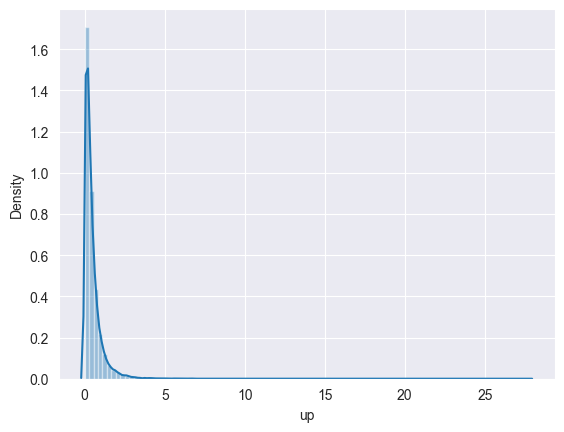

In [35]:
import seaborn as sns
sns.distplot(dataset['up'], bins=100)

<Axes: xlabel='down', ylabel='Density'>

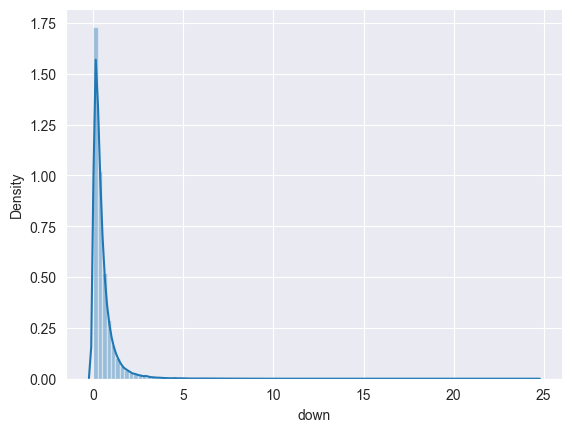

In [36]:
sns.distplot(dataset['down'], bins=100)

Let's deside how many times the price moves more or equal than 1.1% up and down
Why so?
Because commission is 0.1% and I want to make profit at least 1%. So I need to move more than 1.1% up or down to have small profit at least.

In [37]:
ups = dataset[dataset['up'] >= 1.1]
downs = dataset[dataset['down'] >= 1.1]
"Ups", len(ups), f"{len(ups)/len(dataset)*100:.2f}%", "Downs", len(downs), f"{len(downs)/len(dataset)*100:.2f}%"

('Ups', 4065, '9.29%', 'Downs', 4502, '10.29%')

So approximately 20% of the time the price moves more than 1.1% up or down, which is good.
We are looking on 1h candles, so we can make average 4-5 trades per day. 😁
Oh this goddamn commission and statistic 

So let's add new dummy columns represents our three states: 
1. <b>long</b> for going price up for 1.1% or more
2. <b>flat</b> when price not went up or down for 1.1%
3. <b>short</b> for going price down for 1.1% or more 

<b>pr_class</b> is extra parameter that represents all in one class:
0 - long, 1 - flat, 2 - short, 3 - long and short

<b>move</b> is transformation of up-down parameter, that represents the maximum movement up or down in this candle, for regression

In [38]:
dataset["long"] = (dataset["up"] >= 1.1).astype(int)
dataset["flat"] = ((dataset["up"] <= 1.1) & (dataset["down"] <= 1.1)).astype(int)
dataset["short"] = (dataset["down"] >= 1.1).astype(int)

dataset["pr_class"] = 1
dataset.loc[dataset["long"] == 1, "pr_class"] = 0
dataset.loc[dataset["short"] == 1, "pr_class"] = 2
dataset.loc[(dataset["short"] == 1) & (dataset["long"] == 1), "pr_class"] = 3

def _move(up: float, down: float):
    if up > down:
        return up
    else:
        return -down

dataset["move"] = dataset.apply(lambda x: _move(x["up"], x["down"]), axis=1)

dataset.head()

,open_time,open,high,low,close,volume,num_trades,taker_base_vol,up,down,long,flat,short,pr_class,move
0,1541318400000,6388.33,6410.00,6387.00,6408.09,340.668603,4923,208.962466,0.339212,0.020819,0,1,0,1,0.339212
1,1541322000000,6408.66,6415.47,6391.14,6393.12,445.966896,5608,206.470628,0.106262,0.273380,0,1,0,1,-0.273380
2,1541325600000,6393.12,6399.16,6388.10,6398.88,259.283332,4537,126.768854,0.094477,0.078522,0,1,0,1,0.094477
3,1541329200000,6398.88,6414.81,6394.84,6402.54,292.980683,4689,154.843012,0.248950,0.063136,0,1,0,1,0.248950
4,1541332800000,6403.96,6413.00,6402.00,6404.89,320.635364,4870,132.643557,0.141163,0.030606,0,1,0,1,0.141163


<h2>Technical indicators</h2>
And let's also add some technical indicators, because why not? 😉
Joke, I want to see if they have any real dependencies with price movement prediction, will accuracy be better or not.

I will use ta library for technical indicators. And window size will be 24 candles, as 1 day before.

Indicators: RSI, Bollinger Bands, Moving average (simple and exp), MACD, Parabolic SAR, Volume weighted average price

In [39]:
WINDOW = 24

from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD, EMAIndicator, SMAIndicator, PSARIndicator
from ta.volume import VolumeWeightedAveragePrice

dataset['rsi'] = RSIIndicator(dataset['close'], window=WINDOW).rsi()
dataset['bb_bbm'] = BollingerBands(dataset['close'], window=WINDOW, window_dev=2).bollinger_mavg()
dataset['bb_bbh'] = BollingerBands(dataset['close'], window=WINDOW, window_dev=2).bollinger_hband()
dataset['bb_bbl'] = BollingerBands(dataset['close'], window=WINDOW, window_dev=2).bollinger_lband()
dataset['ema'] = EMAIndicator(dataset['close'], window=WINDOW).ema_indicator()
dataset['sma'] = SMAIndicator(dataset['close'], window=WINDOW).sma_indicator()
dataset['macd'] = MACD(dataset['close'], window_slow=26, window_fast=12, window_sign=9).macd()
dataset['psar'] = PSARIndicator(dataset['high'], dataset['low'], dataset['close']).psar()
dataset['vwap'] = VolumeWeightedAveragePrice(dataset['high'], dataset['low'], dataset['close'], dataset['volume'], window=WINDOW).volume_weighted_average_price()
dataset.tail()

,open_time,open,high,low,close,volume,num_trades,taker_base_vol,up,down,...,move,rsi,bb_bbm,bb_bbh,bb_bbl,ema,sma,macd,psar,vwap
43752,1699066800000,34673.76,34729.33,34647.00,34708.90,360.04527,23135,176.78026,0.160265,0.077177,...,0.160265,50.761079,34543.994167,34853.233631,34234.754702,34640.083195,34543.994167,5.735194,34518.908727,34499.076314
43753,1699070400000,34708.91,34724.39,34647.00,34671.02,447.65059,24810,203.62494,0.044599,0.178369,...,-0.178369,49.889966,34555.109583,34862.630897,34247.588270,34642.558140,34555.109583,7.050822,34538.701604,34502.971014
43754,1699074000000,34671.01,34760.00,34585.18,34760.00,833.78335,35704,425.42938,0.256670,0.247556,...,0.256670,51.912705,34564.246250,34882.361974,34246.130526,34651.953489,34564.246250,15.099354,34557.306908,34508.851255
43755,1699077600000,34759.99,35000.00,34720.11,34775.26,2120.49530,73556,1210.11029,0.690478,0.114730,...,0.690478,52.257583,34578.010417,34902.799291,34253.221542,34661.818009,34578.010417,22.450433,34574.795893,34529.499112
43756,1699081200000,34775.27,34874.09,34773.61,34835.87,552.60925,30699,302.25486,0.284167,0.004774,...,0.284167,53.635717,34593.464583,34930.339524,34256.589642,34675.742169,34593.464583,32.788965,34585.180000,34537.669027


In [40]:
# Drop open_time, up, down columns
dataset.drop(columns=['open_time', 'up', 'down'], inplace=True)
# Shift targets to the next candle
dataset['long'] = dataset['long'].shift(-1)
dataset['flat'] = dataset['flat'].shift(-1)
dataset['short'] = dataset['short'].shift(-1)
dataset['pr_class'] = dataset['pr_class'].shift(-1)
dataset['move'] = dataset['move'].shift(-1)
dataset.dropna(inplace=True)
dataset.head()

,open,high,low,close,volume,num_trades,taker_base_vol,long,flat,short,...,move,rsi,bb_bbm,bb_bbh,bb_bbl,ema,sma,macd,psar,vwap
25,6448.39,6464.82,6443.03,6449.25,363.963011,4494,202.759697,0.0,1.0,0.0,...,0.244059,52.041849,6457.537083,6516.022760,6399.051407,6455.959365,6457.537083,8.729509,6510.707494,6461.307174
26,6449.25,6464.99,6448.22,6460.12,363.022111,5173,193.449577,0.0,1.0,0.0,...,-0.144270,54.816191,6460.088750,6513.213132,6406.964368,6456.292216,6460.088750,7.835484,6506.399045,6462.799596
27,6460.12,6465.65,6450.80,6452.84,307.513364,4128,154.936468,0.0,1.0,0.0,...,0.245578,52.686191,6462.184583,6509.738878,6414.630289,6456.016039,6462.184583,6.465004,6502.349102,6464.236973
28,6454.15,6470.00,6452.83,6467.94,415.219256,4601,201.103975,0.0,1.0,0.0,...,0.576611,56.356629,6464.811667,6505.948194,6423.675139,6456.969956,6464.811667,6.522148,6498.542156,6465.937463
29,6467.10,6504.39,6462.21,6475.34,976.399846,7819,518.228827,0.0,1.0,0.0,...,0.274637,58.021922,6467.414167,6502.544113,6432.284220,6458.439559,6467.414167,7.082907,6438.900000,6469.137865


Now let's try to find some dependencies

<Axes: >

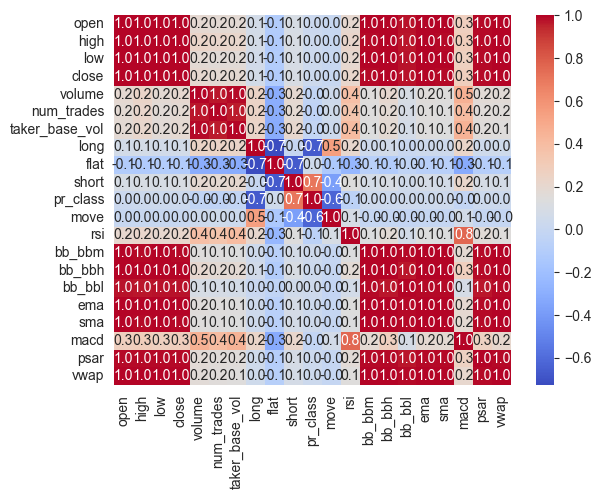

In [41]:
# Trying to find different correlations with heatmap
sns.heatmap(dataset.tail(1000).corr(), annot = True, fmt=".1f", cmap= 'coolwarm')

The best correlation, despite all 'ones' is between flat and volumes/number of trades 

<h1>Prepare data for model</h1>

In [42]:
y_headers = ['long', 'flat', 'short', 'pr_class', 'move']

X_dataset = dataset.drop(columns=y_headers)
y_dataset = dataset[y_headers]
class_labels = ['long', 'flat', 'short', 'long and short']

# Split dataset to X and y
X = X_dataset.values
y = y_dataset.values

# Split dataset to train and test
from sklearn.model_selection import train_test_split
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Scale features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_full = sc.fit_transform(X_train_full)
X_test_full = sc.transform(X_test_full)

# Split X to have set without ta indicators and with ta indicators
X_train_no_ta = X_train_full[:, :7]
X_test_no_ta = X_test_full[:, :7]

# Split y to dummy, regression and classification
y_dummy_train = y_train[:, :-2]
y_dummy_test = y_test[:, :-2]

y_class_train = y_train[:, -2]
y_class_test = y_test[:, -2]

y_reg_train = y_train[:, -1]
y_reg_test = y_test[:, -1]

# Scale regression targets
sc_y = StandardScaler()
y_reg_train = sc_y.fit_transform(y_reg_train.reshape(-1, 1))
y_reg_test = sc_y.transform(y_reg_test.reshape(-1, 1))

<h1>Describe and train models (Classification) </h1>

Here we will try to train different models and compare their results for classification prediction of price movement up or down.

<h2>Random forest</h2>

<h3>Random forest without ta indicators</h3>

In [43]:
# Function for classification full report
def classification_report_full(y_true, y_pred, target_names) -> dict:
    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred, target_names=target_names))
    from sklearn.metrics import accuracy_score
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    return classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

                precision    recall  f1-score   support

          long       0.27      0.08      0.12       721
          flat       0.84      0.98      0.91      7153
         short       0.24      0.07      0.11       778
long and short       0.33      0.09      0.15        95

      accuracy                           0.81      8747
     macro avg       0.42      0.31      0.32      8747
  weighted avg       0.74      0.81      0.76      8747

Accuracy: 0.8123928203955642


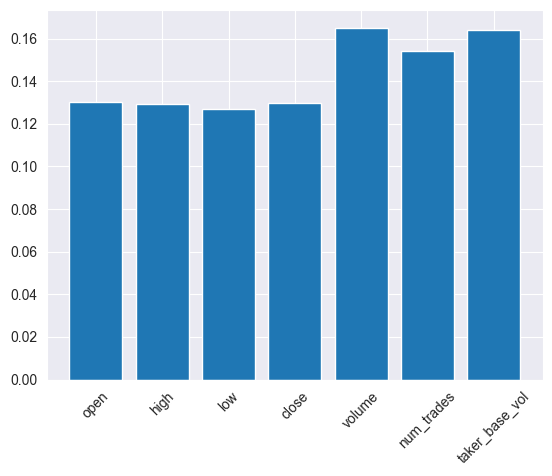

In [44]:
# Train random forest model
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rf_classifier.fit(X_train_no_ta, y_class_train)

# Predict test results
y_pred = rf_classifier.predict(X_test_no_ta)

# Check accuracy
random_forest_no_ta_report = classification_report_full(y_class_test, y_pred, class_labels)

# Check feature importances
importances = rf_classifier.feature_importances_
import matplotlib.pyplot as plt
plt.bar(X_dataset.columns[:len(importances)], importances)
plt.xticks(rotation=45)
plt.show()

As we can see the only acceptable accuracy only for flat state. The model can't predict long and short states properly.

The most important features are volumes and number of trades. It's logical, because the price can't move without volumes and trades 😜

<h3>Random forest with ta indicators</h3>

                precision    recall  f1-score   support

          long       0.29      0.09      0.14       721
          flat       0.85      0.98      0.91      7153
         short       0.30      0.12      0.17       778
long and short       0.30      0.09      0.14        95

      accuracy                           0.82      8747
     macro avg       0.44      0.32      0.34      8747
  weighted avg       0.75      0.82      0.77      8747

Accuracy: 0.817537441408483


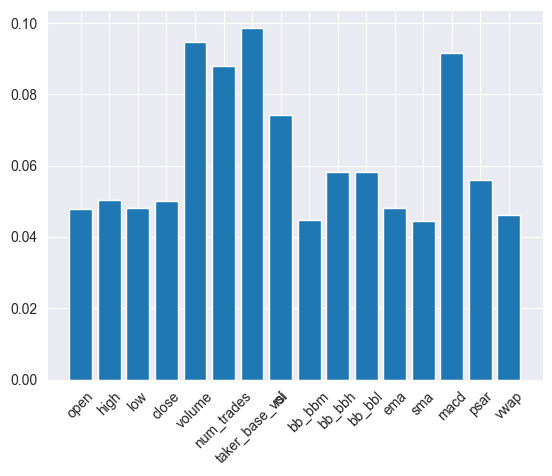

In [45]:
# Train random forest model with ta indicators
rf_classifier_ta = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rf_classifier_ta.fit(X_train_full, y_class_train)

# Predict test results
y_pred = rf_classifier_ta.predict(X_test_full)

# Check accuracy
random_forest_ta_report = classification_report_full(y_class_test, y_pred, class_labels)

# Check feature importances
importances = rf_classifier_ta.feature_importances_
plt.bar(X_dataset.columns, importances)
plt.xticks(rotation=45)
plt.show()

So with ta indicators we can see just little improvement in accuracy for long (+0.01) and short (+0.05) states on recall, but it's not enough.

The most important feature is still volumes. But we can see, that MACD takes second place. It's logical, because MACD is based on moving averages and moving averages are based on prices and many people use them for trading. All other indicators are near the price by their importance.

<h2>Logistic regression</h2>

<h3>Logistic regression without ta indicators</h3>

In [47]:
# Train logistic regression model
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train_no_ta, y_class_train)

# Predict test results
y_pred = logistic_regression.predict(X_test_no_ta)

# Check accuracy
logistic_regression_no_ta_report = classification_report_full(y_class_test, y_pred, class_labels)

                precision    recall  f1-score   support

          long       0.37      0.02      0.04       721
          flat       0.83      1.00      0.90      7153
         short       0.28      0.02      0.04       778
long and short       0.20      0.02      0.04        95

      accuracy                           0.82      8747
     macro avg       0.42      0.26      0.26      8747
  weighted avg       0.73      0.82      0.75      8747

Accuracy: 0.8185663656110667


Logistic regression shows worse results than random forest. The only acceptable accuracy only for flat state (On recall it's full). The model can't predict long and short states properly.

<h3>Logistic regression with ta indicators</h3>

In [48]:
# Train logistic regression model with ta indicators
logistic_regression_ta = LogisticRegression(random_state=42)
logistic_regression_ta.fit(X_train_full, y_class_train)

# Predict test results
y_pred = logistic_regression_ta.predict(X_test_full)

# Check accuracy
logistic_regression_ta_report = classification_report_full(y_class_test, y_pred, class_labels)

                precision    recall  f1-score   support

          long       0.31      0.05      0.08       721
          flat       0.83      0.99      0.90      7153
         short       0.28      0.05      0.08       778
long and short       0.22      0.04      0.07        95

      accuracy                           0.82      8747
     macro avg       0.41      0.28      0.29      8747
  weighted avg       0.73      0.82      0.75      8747

Accuracy: 0.8169658168514919


Logistic regression with ta indicators shows a little bit better results than without ta indicators. The only acceptable accuracy only for flat state (On recall it's 0.99). But the model still can't predict long and short states properly.

<h2>Support vector machine</h2>

<h3>Support vector machine without ta indicators</h3>

In [50]:
# Train support vector machine model
from sklearn.svm import SVC

def svm(kernel: str) -> dict:
    svm_classifier = SVC(kernel=kernel, random_state=42)
    svm_classifier.fit(X_train_no_ta, y_class_train)
    
    # Predict test results
    y_pred = svm_classifier.predict(X_test_no_ta)

    # Check accuracy
    print(f"Kernel: {kernel}")
    svm_no_ta_report = classification_report_full(y_class_test, y_pred, class_labels)
    return svm_no_ta_report

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_no_ta_reports = [svm(kernel) for kernel in kernels]

Kernel: linear
                precision    recall  f1-score   support

          long       0.00      0.00      0.00       721
          flat       0.82      1.00      0.90      7153
         short       0.00      0.00      0.00       778
long and short       0.00      0.00      0.00        95

      accuracy                           0.82      8747
     macro avg       0.20      0.25      0.22      8747
  weighted avg       0.67      0.82      0.74      8747

Accuracy: 0.8177660912312793
Kernel: poly
                precision    recall  f1-score   support

          long       0.00      0.00      0.00       721
          flat       0.82      1.00      0.90      7153
         short       0.33      0.00      0.01       778
long and short       0.00      0.00      0.00        95

      accuracy                           0.82      8747
     macro avg       0.29      0.25      0.23      8747
  weighted avg       0.70      0.82      0.74      8747

Accuracy: 0.8178804161426775
Kernel: rbf


SVM shows worse result than even logistic regression. Sometimes even flat results are not acceptable, but it's better than random. Sometimes we have 0.0 recall... So bad result is result too 😁

<h3>Support vector machine with ta indicators</h3>

In [52]:
# Train support vector machine model with ta indicators

def svm_with_ta(kernel: str) -> dict:
    svm_classifier = SVC(kernel=kernel, random_state=42)
    svm_classifier.fit(X_train_full, y_class_train)
    
    # Predict test results
    y_pred = svm_classifier.predict(X_test_full)

    # Check accuracy
    print(f"Kernel: {kernel}")
    svm_ta_report = classification_report_full(y_class_test, y_pred, class_labels)
    return svm_ta_report

svm_ta_reports = [svm_with_ta(kernel) for kernel in kernels]

Kernel: linear
                precision    recall  f1-score   support

          long       0.00      0.00      0.00       721
          flat       0.82      1.00      0.90      7153
         short       0.00      0.00      0.00       778
long and short       0.00      0.00      0.00        95

      accuracy                           0.82      8747
     macro avg       0.20      0.25      0.22      8747
  weighted avg       0.67      0.82      0.74      8747

Accuracy: 0.8177660912312793
Kernel: poly
                precision    recall  f1-score   support

          long       0.37      0.01      0.02       721
          flat       0.82      1.00      0.90      7153
         short       0.29      0.01      0.03       778
long and short       0.57      0.04      0.08        95

      accuracy                           0.82      8747
     macro avg       0.51      0.27      0.26      8747
  weighted avg       0.74      0.82      0.74      8747

Accuracy: 0.8194809649022522
Kernel: rbf


SVM with ta indicators shows a little bit better results than without ta indicators, but not much.

<h2>Gradient boosting</h2>

<h3>Gradient boosting without ta indicators</h3>

In [53]:
# Train gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_no_ta, y_class_train)

# Predict test results
y_pred = gb_classifier.predict(X_test_no_ta)

# Check accuracy
gb_no_ta_report = classification_report_full(y_class_test, y_pred, class_labels)

                precision    recall  f1-score   support

          long       0.39      0.04      0.08       721
          flat       0.83      0.99      0.91      7153
         short       0.38      0.04      0.08       778
long and short       0.24      0.12      0.16        95

      accuracy                           0.82      8747
     macro avg       0.46      0.30      0.30      8747
  weighted avg       0.75      0.82      0.76      8747

Accuracy: 0.8203955641934377


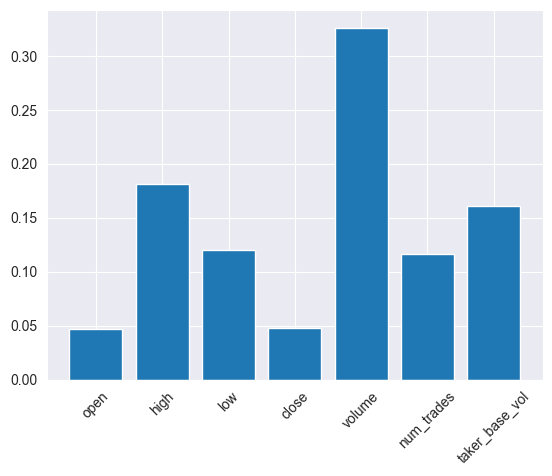

In [54]:
# Check feature importances
importances = gb_classifier.feature_importances_
plt.bar(X_dataset.columns[:len(importances)], importances)
plt.xticks(rotation=45)
plt.show()

Not bad results, but not good too. What is interesting, it shows the best accuracy for long and short states rather than previous models. But it's still not enough. And the most important feature is volumes, like in previous models, but much more important than others.

<h3>Gradient boosting with ta indicators</h3>

In [56]:
# Train gradient boosting model with ta indicators
gb_classifier_ta = GradientBoostingClassifier(random_state=42)
gb_classifier_ta.fit(X_train_full, y_class_train)

# Predict test results
y_pred = gb_classifier_ta.predict(X_test_full)

# Check accuracy
gb_ta_report = classification_report_full(y_class_test, y_pred, class_labels)

                precision    recall  f1-score   support

          long       0.32      0.05      0.08       721
          flat       0.84      0.99      0.91      7153
         short       0.29      0.06      0.10       778
long and short       0.20      0.06      0.10        95

      accuracy                           0.82      8747
     macro avg       0.41      0.29      0.30      8747
  weighted avg       0.74      0.82      0.76      8747

Accuracy: 0.8208528638390306


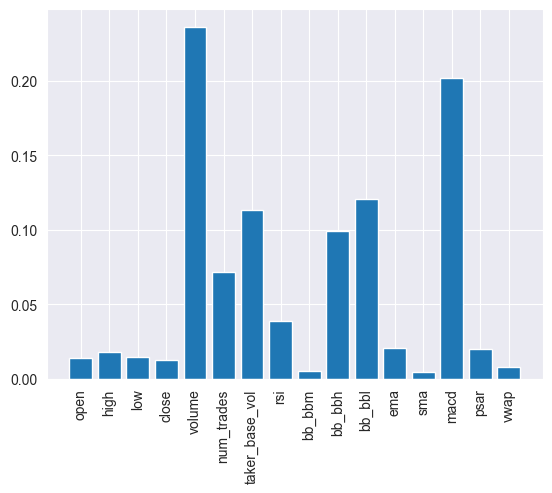

In [58]:
# Check feature importances
importances = gb_classifier_ta.feature_importances_
plt.bar(X_dataset.columns, importances)
plt.xticks(rotation=90)
plt.show()

Here we see more uniform results for all move states and long and short now is not so good. But the most important feature is still volumes, like in previous models, but much more important than others and MACD is second. What is interesting, Bollinger's high and low bands are more important than middle band. 